# Цель работы

**Цель** - написать систему алертов, которая будет оповещать, если поведение данных будет необычным (например, сильные выбросы).

**Идея** - с помощью стат методов написать функцию поиска аномалий в данных, а затем отправлять оповещение в чат, если такие будут обнаружены.

**Задачи**:

1. Пишем функцию поиска аномалий (например, метод размахов + среднее отклонение)
2. Далее пишем функцию, которая будет создавать оповещение и отсылать в чат сообщение.

*Сам скрипт DAGа в конце*

# Алерт

## Загрузка необходимых элементов для бота

In [73]:
# Загружаем необходимые библиотеки
import datetime
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse

In [89]:
def create_data(connection=None, query=None):
    
    connection = connection or {
                                'host': 'https://clickhouse.lab.karpov.courses',
                                'password': 'dpo_python_2020',
                                'user': 'student',
                                'database': 'simulator_20230320'
                               }
    
    query =  query or '''
                        SELECT
                              *
                        FROM    
                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_feed,
                                  countIf(user_id, action = 'view') as views,
                                  countIf(user_id, action = 'like') as likes,
                                  likes / views as CTR
                            FROM simulator_20230320.feed_actions
                            WHERE time >= today() - 1 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) f

                            FULL JOIN

                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_messager,
                                  COUNT (user_id) as sent_messages
                            FROM simulator_20230320.message_actions
                            WHERE time >= today() - 1 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) m

                            USING ts
                            ORDER BY ts
                      '''
    
    data = pandahouse.read_clickhouse(query, connection=connection)
    
    return data


def ru_metrics(metric):
    '''
    Функция возвращает название метрики на русском языке
    '''
    ru_metrics = {'users_feed': 'Активные пользователи (лента)',
                  'users_messager': 'Активные пользователи (мессенджер)',
                  'views': 'Просмотры', 
                  'likes': 'Лайки', 
                  'CTR': 'CTR',  
                  'sent_messages': 'Сообщения'}
    
    return ru_metrics[metric]

def check_anomaly_1(df, metric, a=4, n=4):
    '''
    Функция, которая ищет аномалии в данных.
    Стат. метод - межквартильный размах 
    '''
    df_1.iloc[-6:-1]
    df['q25'] = df[metric].shift(1).rolling(n).quantile(0.25)
    df['q75'] = df[metric].shift(1).rolling(n).quantile(0.75)
    df['iqr'] = df['q75'] - df['q25'] # межквартильный размах
    df['up'] = df['q75'] + a * df['iqr'] # верхняя граница доверительного интервала
    df['low'] = df['q25'] - a * df['iqr'] # нижняя граница доверительного интервала
    
    #Сглаживание границ ДИ - скользящее среднее
    df['up'] = df['up'].rolling(n, center=True, min_periods=1).mean()
    df['low'] = df['low'].rolling(n, center=True, min_periods=1).mean()
    
    # пишем проверку на наличие выбросов из доверительного интервала
    if df[metric].iloc[-1] < df['low'].iloc[-1] or df[metric].iloc[-1] > df['up'].iloc[-1]:
        is_alert = 1 # нашли выброс
    else:
        is_alert = 0 # все хорошо
    
    return is_alert, df

def check_anomaly_2(df, metric):
    '''
    Функция, которая ищет аномалии в данных.
    Метод - сравние с предыдущим днем (значение пред дня +- стандартное отклонение за последние 7 дней)
    '''
    # берем вчерашнюю дату
    condition = df.date != df.date.iloc[-1]
    # создаем датафрейм только из вчерашних дат
    yesterday_df = df[condition]
    yesterday_value = yesterday_df[yesterday_df['hm'] == df['hm'].iloc[-1]][metric] # Получаем значение вчерашнего дня по метрике
    
    # рассчет оклонения
    query = '''
                        SELECT
                              *
                        FROM    
                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_feed,
                                  countIf(user_id, action = 'view') as views,
                                  countIf(user_id, action = 'like') as likes,
                                  likes / views as CTR
                            FROM simulator_20230320.feed_actions
                            WHERE time >= today() - 7 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) f

                            FULL JOIN

                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_messager,
                                  COUNT (user_id) as sent_messages
                            FROM simulator_20230320.message_actions
                            WHERE time >= today() - 7 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) m

                            USING ts
                            ORDER BY ts
                        '''
    
    df_7 = create_data(query=query)
    condition = df_7['hm'] == df['hm'].iloc[-1]
    std_metric = round(df_7[condition][:-1][metric].std())
    
    if df[metric].iloc[-1] > yesterday_value.iloc[0] + std_metric or df[metric].iloc[-1] < yesterday_value.iloc[0] - std_metric:
        is_alert_2 = 1 
    else:
        is_alert_2 = 0
        
    return is_alert_2

def run_alerts(chat=None, query=None):
    '''
    Система, которая запускает алерт - отправляет сообщение о том, что есть выбросы
    '''
    chat_id = chat or 1013581629 # id чата или мой бот
    my_token = '6245347830:AAHFIuYvAh9YxKR4taSMoQHNA0GuelpvUrA' # токен
    bot = telegram.Bot(token=my_token)
    
    # Создаем датафрейм
    
    data = create_data()
    
    metrics_list = ['users_feed', 'users_messager', 'views', 'likes', 'CTR',  'sent_messages']
    for metric in metrics_list:
        df = data[['ts', 'date', 'hm', metric]].copy()
        
        is_alert, df= check_anomaly_1(df, metric)
        is_alert_2 = check_anomaly_2(df, metric)
            
        if is_alert == 1 and is_alert_2 == 1:
            msg = 'Метрика "{metric_name}":\n'.format(metric_name=ru_metrics(metric)) + \
                  '- текущее значение {current_val:.2f}\n'.format(current_val=df[metric].iloc[-1]) + \
                  '- отклонение от предыдущего значения {last_val_diff:.2%}\n'.format (last_val_diff=abs(1 - (df[metric].iloc[-1] / df[metric].iloc[-2]))) + \
                  'Ссылка на оперативный дашборд: https://superset.lab.karpov.courses/superset/dashboard/3362/'

            sns.set(rc={'figure.figsize': (16, 10)}) # Размер графика
            sns.set_style("whitegrid")
            plt.tight_layout() # отрегулирует расстояние между подграфиками, чтобы свести к минимуму перекрытия

            ax = sns.lineplot(x=df['ts'], y=df[metric], label=ru_metrics(metric))
            ax = sns.lineplot(x=df['ts'], y=df['up'], label='Верхняя граница')
            ax = sns.lineplot(x=df['ts'], y=df['low'], label='Нижняя граница')

            for ind, label in enumerate(ax.get_xticklabels()):
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)

            ax.set(xlabel='Время')
            ax.set(ylabel=ru_metrics(metric))
            ax.set_title(ru_metrics(metric), fontsize=16, fontweight='bold')
            #ax.set(ylim=(0, None))
            
            # Сохраняем в буфер
            plot_object = io.BytesIO()
            plt.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{metric}.png'.format(metric=metric)
            plt.close()

            bot.sendPhoto(chat_id=chat_id, photo=plot_object, caption=msg)

In [90]:
run_alerts = run_alerts()

In [80]:
df = create_data()

In [82]:
    metric = 'users_messager'
    # берем вчерашнюю дату
    condition = df.date != df.date.iloc[-1]
    # создаем датафрейм только из вчерашних дат
    yesterday_df = df[condition]
    yesterday_value = yesterday_df[yesterday_df['hm'] == df['hm'].iloc[-1]][metric] # Получаем значение вчерашнего дня по метрике
    
    # рассчет оклонения
    query = '''
                        SELECT
                              *
                        FROM    
                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_feed,
                                  countIf(user_id, action = 'view') as views,
                                  countIf(user_id, action = 'like') as likes,
                                  likes / views as CTR
                            FROM simulator_20230320.feed_actions
                            WHERE time >= today() - 7 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) f

                            FULL JOIN

                            (SELECT
                                  toStartOfFifteenMinutes(time) as ts,
                                  toDate(time) as date,
                                  formatDateTime(ts, '%R') as hm,
                                  uniqExact(user_id) as users_messager,
                                  COUNT (user_id) as sent_messages
                            FROM simulator_20230320.message_actions
                            WHERE time >= today() - 7 and time < toStartOfFifteenMinutes(now())
                            GROUP BY ts, date, hm) m

                            USING ts
                            ORDER BY ts
                        '''
    
    df_7 = create_data(query=query)
    condition = df_7['hm'] == df['hm'].iloc[-1]
    std_metric = round(df_7[condition][:-1][metric].std())
    
    if df[metric].iloc[-1] > yesterday_value.iloc[0] + std_metric or df[metric].iloc[-1] < yesterday_value.iloc[0] - std_metric:
        is_alert_2 = 1 
    else:
        is_alert_2 = 0

In [85]:
df_7[metric] + std_metric

0       90
1       72
2       79
3       78
4       74
      ... 
734    156
735    154
736    151
737    162
738    177
Name: users_messager, Length: 739, dtype: uint64

Text(0.5, 1.0, 'Активные пользователи (мессенджер)')

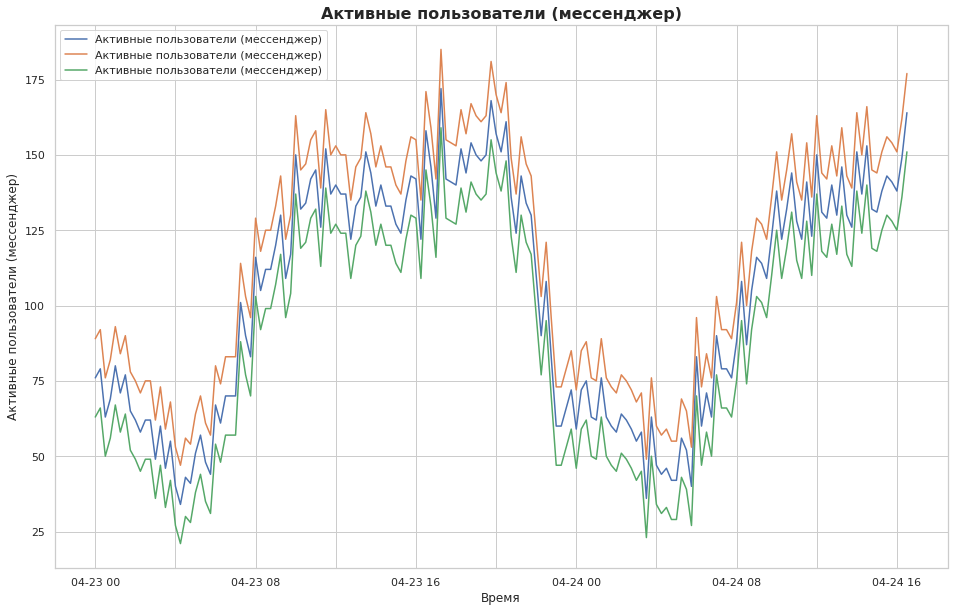

In [88]:
            sns.set(rc={'figure.figsize': (16, 10)}) # Размер графика
            sns.set_style("whitegrid")
            plt.tight_layout() # отрегулирует расстояние между подграфиками, чтобы свести к минимуму перекрытия

            ax = sns.lineplot(x=df['ts'], y=df[metric], label=ru_metrics(metric))
            ax = sns.lineplot(x=df['ts'], y=df[metric] + std_metric, label=ru_metrics(metric))
            ax = sns.lineplot(x=df['ts'], y=df[metric] - std_metric, label=ru_metrics(metric))
            
            for ind, label in enumerate(ax.get_xticklabels()):
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)

            ax.set(xlabel='Время')
            ax.set(ylabel=ru_metrics(metric))
            ax.set_title(ru_metrics(metric), fontsize=16, fontweight='bold')
            #ax.set(ylim=(0, None))

# Код Дага